In [1]:
from __init__ import *
import os
import sys
import re

import utils

# Configs  

In [2]:
# data directory
DATA_DIR = "./data_11mods_it"

# this integration
f_results_scf_11mods_mop = "./results/integration_results_scf_11mods_it_mop.tsv"

# reference (compare with previous integrations)
f_rnacons = './ref/cluster_annotation_mop_rna_consensus_yao2020.tsv'
f_scf = './ref/cluster_annotation_mop_scf_level2_yao2020.tsv'
f_results_scf_8mods_mop = './ref/cell_cluster_assignment_mop_all_intg_yao2020.tsv'

In [3]:
# datasets
sys.path.insert(0, DATA_DIR)
from __init__datasets import *

mods_ordered = [
                 'smarter_cells',
                 '10x_cells_v3',
                 '10x_cells_v2',
                 'smarter_nuclei',
                 '10x_nuclei_v3_macosko',
                 '10x_nuclei_v3',
    
                 'snatac_gene',
                 'snmcseq_gene',
    
                 'patchseq',
                 'epi_retro', 
                 'merfish',
                ]

# Read in data 

In [4]:
# dataset specific metadata
meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
metas = collections.OrderedDict()
for mod in mods_ordered:
    meta = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    meta = meta.astype(dtype={settings[mod].annot_col: str})
    metas[mod] = meta
    print(mod, metas[mod].shape)

smarter_cells (2450, 129)
10x_cells_v3 (45075, 8)
10x_cells_v2 (63239, 8)
smarter_nuclei (2304, 146)
10x_nuclei_v3_macosko (59639, 19)
10x_nuclei_v3 (21813, 8)
snatac_gene (32967, 13)
snmcseq_gene (5339, 32)
patchseq (253, 115)
epi_retro (1110, 12)
merfish (112080, 15)


In [5]:
# get integration results (11 modalities IT cells) summary
df_info = pd.read_csv(f_results_scf_11mods_mop, sep="\t", index_col='sample') 
df_info = df_info.rename({
                          'tsne_x': 'tsne_x_joint',
                          'tsne_y': 'tsne_y_joint',
                         }, axis=1)
df_info['modality_name'] = df_info['modality'].apply(lambda mod: settings[mod].name)

# add single-modality cluster, annot info
df_info['cluster'] = ''
df_info['annot'] = ''
for mod in mods_ordered:
    _cells = metas[mod].index.values
    df_info.loc[_cells, 'cluster'] = metas[mod].loc[_cells, settings[mod].cluster_col]
    df_info.loc[_cells, 'annot'] = metas[mod].loc[_cells, settings[mod].annot_col]
# clean up annotation
df_info['annot'] = df_info['annot'].str.replace('_Glutamatergic', '')
df_info['annot'] = df_info['annot'].str.replace('_GABAergic', '')
df_info['annot'] = df_info['annot'].fillna(df_info['cluster'])

# get info
print(df_info.shape)
print(df_info.groupby('modality').size())
df_info.head()

(346269, 7)
modality
10x_cells_v2              63239
10x_cells_v3              45075
10x_nuclei_v3             21813
10x_nuclei_v3_macosko     59639
epi_retro                  1110
merfish                  112080
patchseq                    253
smarter_cells              2450
smarter_nuclei             2304
snatac_gene               32967
snmcseq_gene               5339
dtype: int64


,cluster_joint_r0.2,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot
sample,,,,,,,
snmcseq_gene_2C_M_0,1,2.345971,-9.284725,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Tenm2,L4-IT-Rorb_Rorb-Tenm2
snmcseq_gene_2C_M_1,2,4.103980,2.221154,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2
snmcseq_gene_2C_M_100,2,3.577672,3.489669,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2
snmcseq_gene_2C_M_1000,2,6.604176,7.755098,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2
snmcseq_gene_2C_M_1001,2,2.008680,3.267917,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2


In [6]:
df_rna_annot = pd.read_csv(f_rnacons, sep='\t', index_col=0)
def rename_rna(x):
    if x == -1:
        return np.nan
    else:
        return df_rna_annot.loc[int(x), 'annot']
    
df_scf_annot = pd.read_csv(f_scf, sep='\t', index_col=0)
def rename_scf_r3(x):
    if x == -1:
        return np.nan
    else:
        return df_scf_annot.loc[x, 'annot']
    
def rename_liger(x):
    if x == -1:
        return np.nan
    else:
        return x
    

df_info2 = pd.read_csv(f_results_scf_8mods_mop, sep='\t', index_col=0)
df_info2['RNA concensus'] = df_info2['RNA concensus'].fillna(-1).apply(rename_rna)
df_info2['SCF_round3'] = df_info2['SCF_round3'].fillna(-1).apply(rename_scf_r3)
df_info2['LIGER_level2'] = df_info2['LIGER_level2'].fillna(-1).apply(rename_liger)

df_info = df_info.join(df_info2.drop('modality', axis=1))
df_info.head()

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,2,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,cluster_joint_r0.2,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot,SCF_round2,SCF_round3,RNA concensus,LIGER_level1,LIGER_level2
sample,,,,,,,,,,,,
snmcseq_gene_2C_M_0,1,2.345971,-9.284725,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Tenm2,L4-IT-Rorb_Rorb-Tenm2,1-1,L4/5 IT (1),NaN,0,it_8
snmcseq_gene_2C_M_1,2,4.103980,2.221154,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-2,L2/3 IT (3),NaN,1,it_0
snmcseq_gene_2C_M_100,2,3.577672,3.489669,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-1,L2/3 IT (1),NaN,1,it_0
snmcseq_gene_2C_M_1000,2,6.604176,7.755098,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-2,L2/3 IT (3),NaN,1,it_0
snmcseq_gene_2C_M_1001,2,2.008680,3.267917,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4-1,L2/3 IT (1),NaN,1,it_0


# Make plots 

In [7]:
joint_cluster = 'cluster_joint_r0.2'

# mod colors and names
mod_colors = collections.OrderedDict({mod: settings[mod].color for mod in mods_ordered})
mod_names = {mod: settings[mod].name for mod in mods_ordered}

# get cluster centroids
centroids = {}
_x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())
for mod in mods_ordered:
    centroids[mod] = _x.loc[mod, :]
centroids['joint'] = (df_info[['tsne_x_joint', 'tsne_y_joint', joint_cluster]]
             .groupby([joint_cluster]).median())

# get annotation for joint clusters 
joint_annot = df_info[df_info['modality'].isin(mods_ordered)].groupby([joint_cluster]).agg({'annot': lambda x: x.value_counts().index.values[0]})

# get uniq colors for joint clusters  
clsts = np.sort(df_info[joint_cluster].unique())
colors = utils.gen_colors(len(clsts))
joint_clst_colors = {clst: color for clst, color in zip(clsts, colors)}

# histograms
hist = df_info.groupby([joint_cluster, 'modality']).size().unstack().fillna(0).astype(int)
hist_mod = hist.sum(axis=0)
hist_clst = hist.sum(axis=1)

hist_frac = hist.divide(hist_clst, axis=0)
hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
             index=hist_clst.index, columns=hist_mod.index.values)
hist_enrich = (hist+1)/(hist_exp+1)

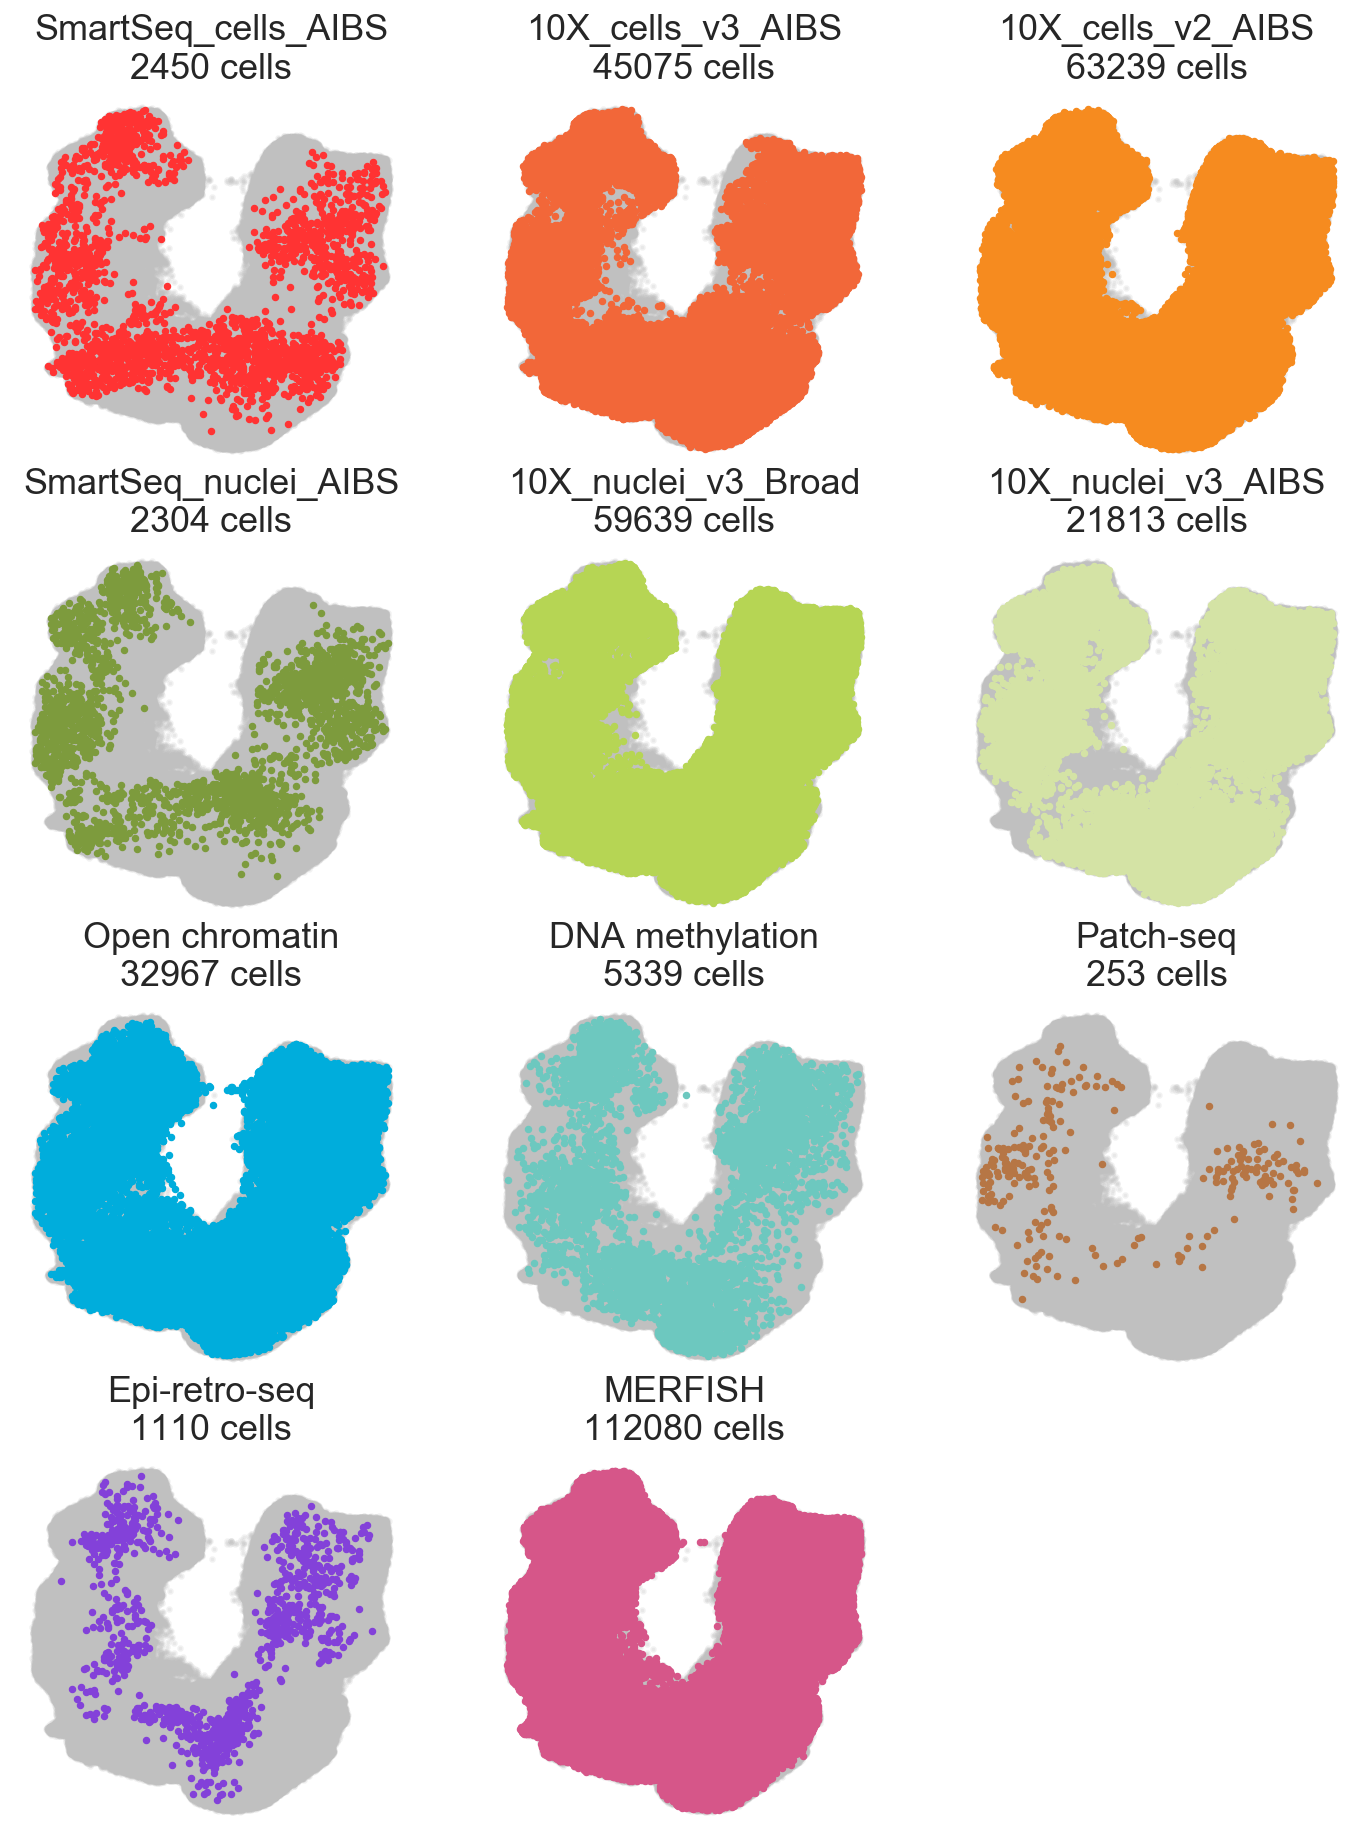

In [8]:
n = len(mods_ordered)
nx = 3
ny = int((n+nx-1)/nx)
    
fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
axs = axs.flatten()
for mod, ax in zip(mods_ordered, axs):
    ax.scatter(df_info['tsne_x_joint'].values, 
                df_info['tsne_y_joint'].values, 
                s=3,
                alpha=0.2,
                rasterized=True,
                color='silver')
    ax.scatter(df_info.loc[df_info['modality']==mod, 'tsne_x_joint'].values, 
                df_info.loc[df_info['modality']==mod, 'tsne_y_joint'].values, 
                s=5,
                alpha=1,
                rasterized=True,
                color=settings[mod].color)
    ax.set_title("{}\n{} cells".format(settings[mod].name, len(df_info[df_info['modality']==mod])))
    ax.axis('off')

for ax in axs[n:]:
    ax.axis('off')

# fig.savefig(output_figures.format('plot_n0', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [9]:
it_cond = df_info['annot'].str.contains(r'IT|L2/3|L4|^E[0-9]|L23')
it_pattern = re.compile(r"(.*IT|^E[0-9]|L2/3|L4|^it_|L23)")


print(df_info.shape, 
      df_info[it_cond].shape, 
     )

(346269, 12) (346140, 12)


In [10]:
print(
#     df_info['annot'].unique(), 
    np.sort(np.array([clst for clst in df_info['annot'].unique() if not it_pattern.match(clst)])),
    np.sort(df_info.loc[~it_cond, 'annot'].unique()),
)
    
df_info.loc[~it_cond, 'modality'].value_counts()

['L5 ET_1' 'L5 ET_2' 'L5 ET_4' 'L6 CT Brinp3' 'L6 CT Cpa6_1'
 'L6 CT Cpa6_2' 'L6b Ror1' 'L6b Shisa6' 'Outlier'] ['L5 ET_1' 'L5 ET_2' 'L5 ET_4' 'L6 CT Brinp3' 'L6 CT Cpa6_1'
 'L6 CT Cpa6_2' 'L6b Ror1' 'L6b Shisa6' 'Outlier']


snmcseq_gene             110
10x_cells_v3              12
10x_nuclei_v3              4
10x_nuclei_v3_macosko      2
smarter_nuclei             1
Name: modality, dtype: int64

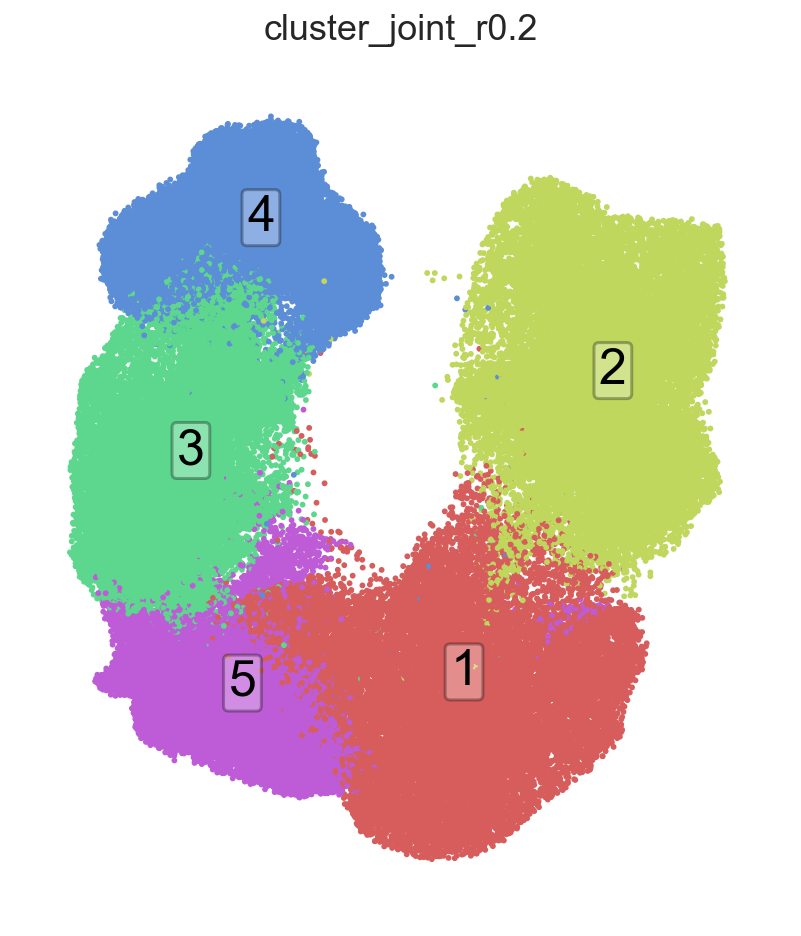

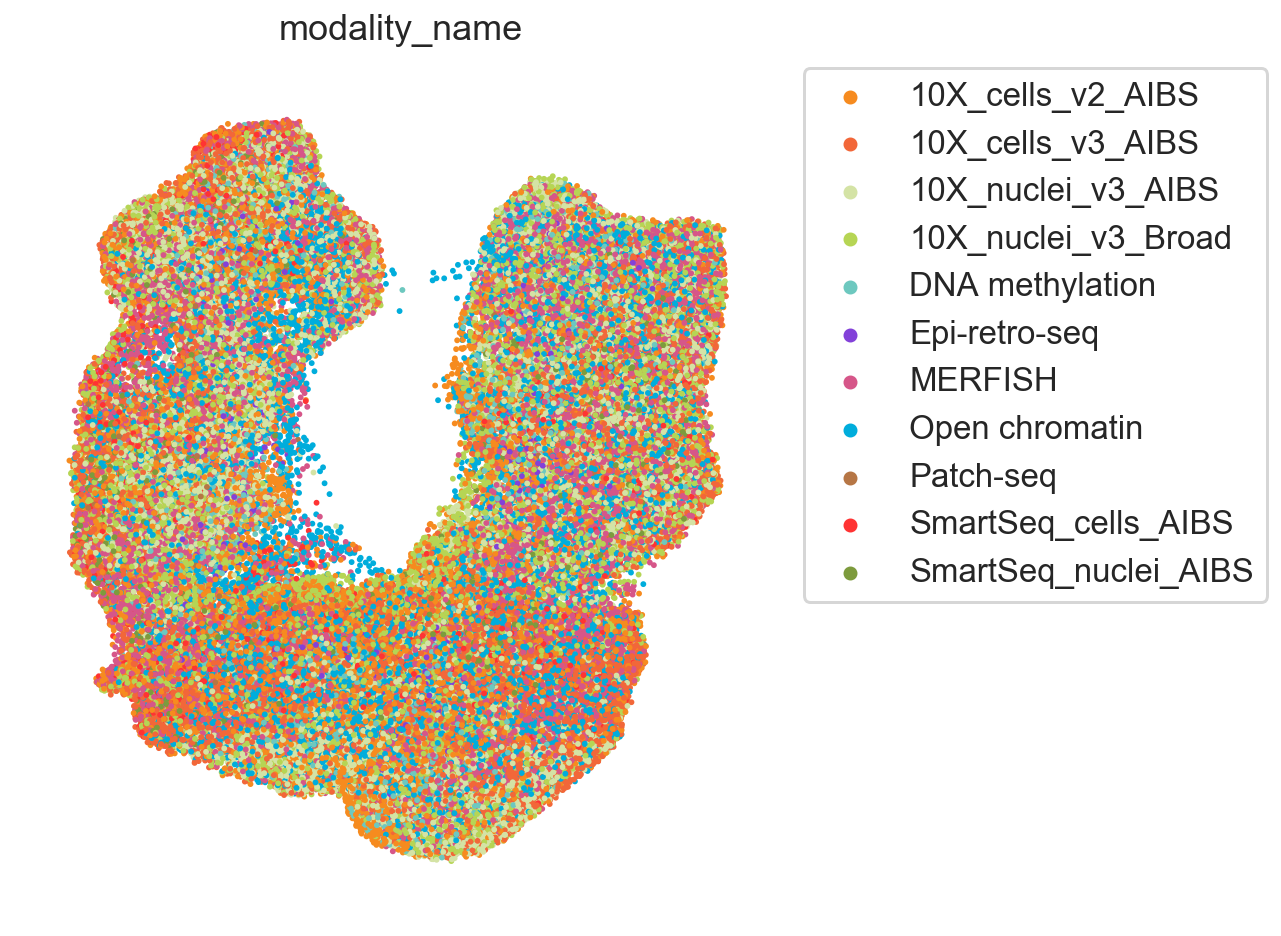

In [11]:
sample_n = 20000

fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', joint_cluster
legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                  sample_n=sample_n,
                                  legend_size=30,
                                  rasterized=True,
                                  kw_colors=joint_clst_colors,
                                  legend_mode=-1,
                                  s=2,
                                 )
ax.set_aspect('equal')
ax.axis('off')
for clst, centroid in centroids['joint'].iterrows():
    facecolor='white'
    ax.text(centroid.values[0], 
            centroid.values[1], 
            str(clst),
            color='black', 
            bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
            fontsize=25,
           )
plt.show()
        

fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
kw_colors = {settings[mod].name: settings[mod].color for mod in mods_ordered}
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                  legend_kws=legend_kws,
                                  sample_n=sample_n,
                                  legend_size=30,
                                  rasterized=True,
                                  kw_colors=kw_colors,
                                  s=2,
                                 )
ax.set_aspect('equal')
ax.axis('off')
plt.show()

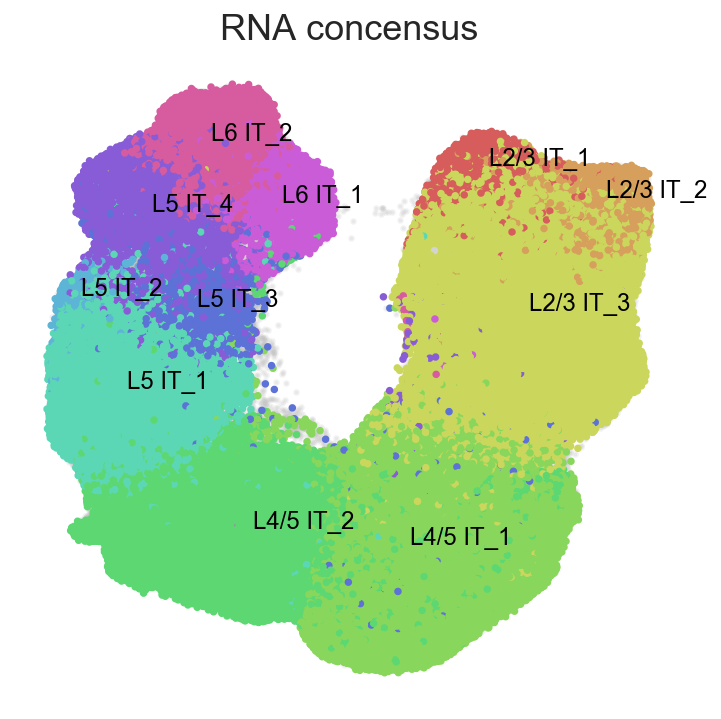

In [12]:
show_labels = True
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'RNA concensus'
cond = df_info[tc].isnull()

fig, ax = plt.subplots(figsize=(6, 6))
# background
ax.scatter(df_info.loc[cond, tx].values, 
           df_info.loc[cond, ty].values, 
           s=3,
           alpha=0.2,
           rasterized=True,
           color='silver')

# get uniq colors for joint clusters  
df_plot = df_info[~cond]
cluster_centroids = (df_plot[[tx, ty, tc]].groupby([tc]).median())
clsts = np.sort(df_plot[tc].unique())
clsts_pt = [clst for clst in clsts if it_pattern.match(clst) and 'Car3' not in clst]
colors = utils.gen_colors(len(clsts_pt))
palette = {clst: color for clst, color in zip(clsts_pt, colors)}
for clst in clsts:
    if clst not in clsts_pt:
        palette[clst] = 'lightgray'
        
# plot joint cluster
utils.plot_tsne_labels_ax(df_plot, ax, tx, ty, tc, 
                                  t_xlim=None, t_ylim=None,
                                  rasterized=True,
                                  legend_mode=-1,
                                  kw_colors=palette,
                                  s=5,
                                 )
# cluster labels
if show_labels:
    for clst, centroid in cluster_centroids.iterrows():
        if clst in clsts_pt:
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    str(clst),
                    color='black', 
                    fontsize=12,
                   )

ax.set_title(tc) 
ax.axis('off')

# fig.savefig(output_figures.format('plot_RNAconcensus-labeled', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

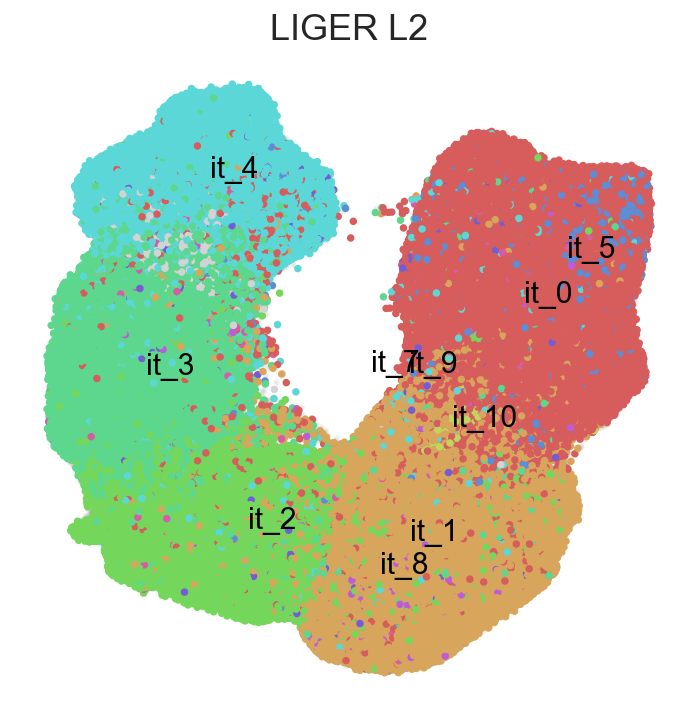

In [13]:
show_labels = True
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'LIGER_level2'
cond = df_info[tc].isnull()

fig, ax = plt.subplots(figsize=(6, 6))
# background
ax.scatter(df_info.loc[cond, tx].values, 
           df_info.loc[cond, ty].values, 
           s=3,
           alpha=0.2,
           rasterized=True,
           color='silver')

# get uniq colors for joint clusters  
df_plot = df_info[~cond]
cluster_centroids = (df_plot[[tx, ty, tc]].groupby([tc]).median())
clsts = np.sort(df_plot[tc].unique())
clsts_it = [clst for clst in clsts if it_pattern.match(clst) and 'it_6' not in clst]
colors = utils.gen_colors(len(clsts_it))
palette = {clst: color for clst, color in zip(clsts_it, colors)}
for clst in clsts:
    if clst not in clsts_it:
        palette[clst] = 'lightgray'
        
# plot joint cluster
utils.plot_tsne_labels_ax(df_plot, ax, tx, ty, tc, 
                                  t_xlim=None, t_ylim=None,
                                  rasterized=True,
                                  legend_mode=-1,
                                  kw_colors=palette,
                                  s=5,
                                 )
# cluster labels
if show_labels:
    for clst, centroid in cluster_centroids.iterrows():
        if clst in clsts_it:
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    str(clst),
                    color='black', 
                    fontsize=15,
                   )

ax.set_title('LIGER L2') 
ax.axis('off')

# fig.savefig(output_figures.format('plot_LIGER_L2-labeled', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

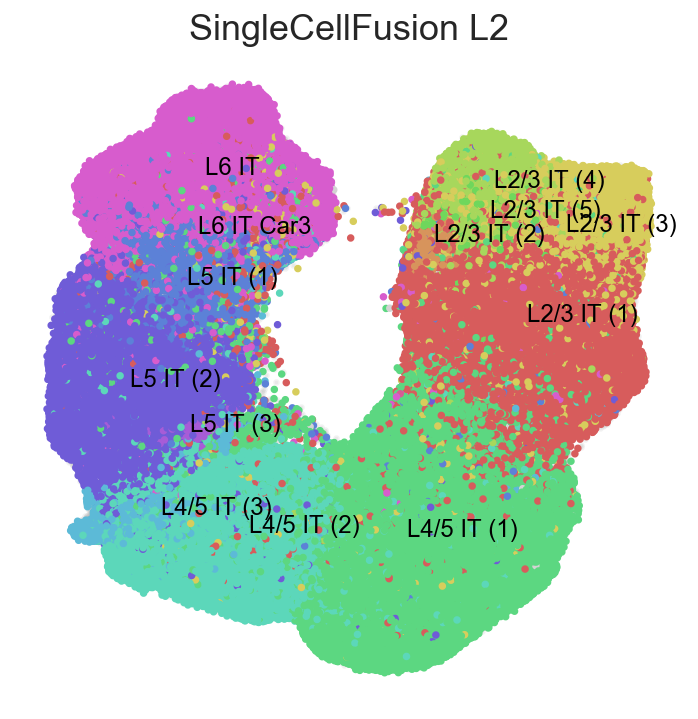

In [14]:
show_labels = True
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'SCF_round3'
cond = df_info[tc].isnull()

fig, ax = plt.subplots(figsize=(6, 6))
# background
ax.scatter(df_info.loc[cond, tx].values, 
           df_info.loc[cond, ty].values, 
           s=3,
           alpha=0.2,
           rasterized=True,
           color='silver')

# get uniq colors for joint clusters  
df_plot = df_info[~cond]
cluster_centroids = (df_plot[[tx, ty, tc]].groupby([tc]).median())
clsts = np.sort(df_plot[tc].unique())
clsts_it = [clst for clst in clsts if it_pattern.match(clst)]
colors = utils.gen_colors(len(clsts_it))
palette = {clst: color for clst, color in zip(clsts_it, colors)}
for clst in clsts:
    if clst not in clsts_it:
        palette[clst] = 'lightgray'
        
# plot joint cluster
utils.plot_tsne_labels_ax(df_plot, ax, tx, ty, tc, 
                                  t_xlim=None, t_ylim=None,
                                  rasterized=True,
                                  legend_mode=-1,
                                  kw_colors=palette,
                                  s=5,
                                 )
# cluster labels
if show_labels:
    for clst, centroid in cluster_centroids.iterrows():
        if clst in clsts_it:
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    str(clst),
                    color='black', 
                    fontsize=12,
                   )

ax.set_title('SingleCellFusion L2') 
ax.axis('off')

# fig.savefig(output_figures.format('plot_SCF-labeled', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

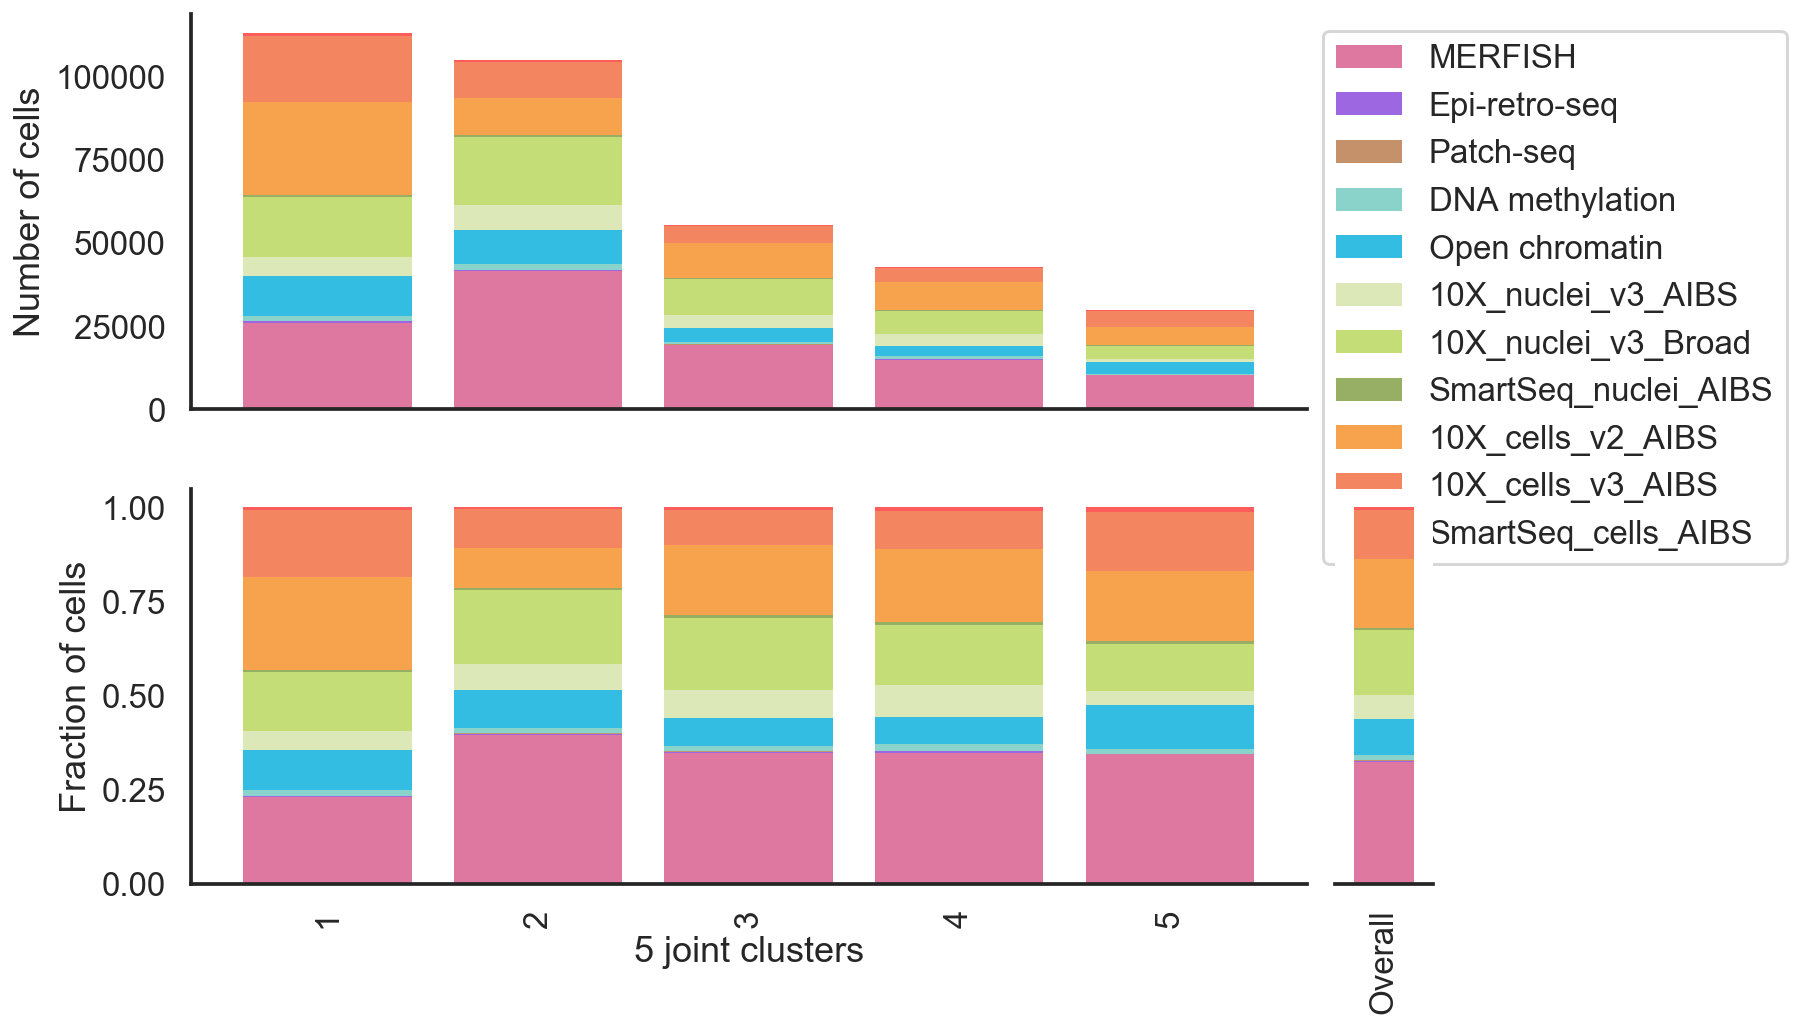

In [15]:
# histograms
with sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    fig, axs = plt.subplots(2, 1, figsize=(10,4*2))
    ax = axs[0]
    hist[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names).plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylabel('Number of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    

    ax = axs[1]
    hist_frac[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names).plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('Fraction of cells')
    ax.set_xlabel('{} joint clusters'.format(len(hist)))
#     ax.set_xticklabels([])
    
#     ax = fig.add_axes([.95, .5, .05, .4])
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    ((hist_mod/hist_mod.sum()).loc[mods_ordered[::-1]].to_frame().T.rename({0: 'Overall'}, axis=0)
                      .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                      color=[val for key, val in mod_colors.items()][::-1]) # this controls mod_colors
    )
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
#     fig.tight_layout()
#     fig.savefig(output_figures.format('plot_4_hist', 'pdf'), bbox_inches='tight')
    plt.show()

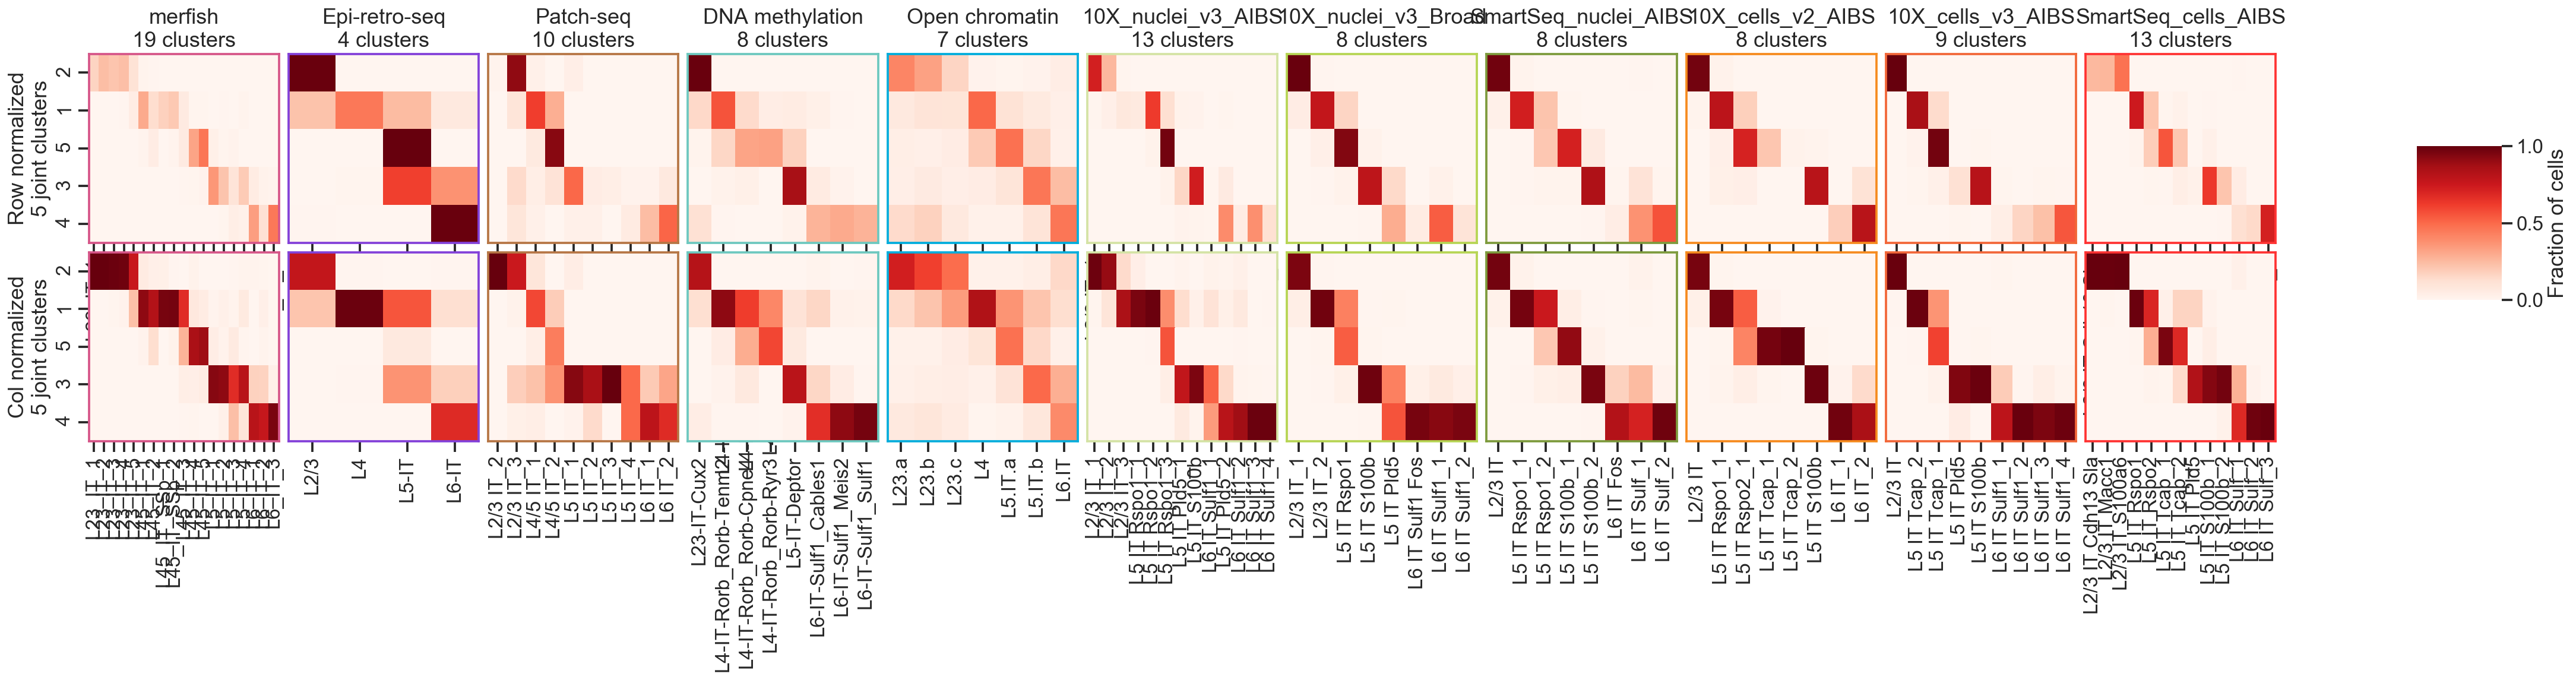

In [16]:
# confusion matrix

nx = len(mods_ordered)
ny = 2
order_joint = [2, 1, 5, 3, 4,]
heatmap_kws = {
    'xticklabels': True, 
    'yticklabels': True,
    'vmin': 0, 
    'vmax': 1,
    'cmap': 'Reds',
}

cbar_kws = {
    'orientation': 'vertical', 
    'label': 'Fraction of cells',
}


with sns.plotting_context('talk'):
    fig, axs = plt.subplots(ny, nx, figsize=(3*nx, 3*ny))
    axs = axs.T
    cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
    njoint_clusters = len(df_info[joint_cluster].unique())
    for i, (mod, ax) in enumerate(zip(mods_ordered[::-1], axs)):
        conf_mat = pd.crosstab(df_info.loc[((df_info['modality']==mod) & (it_cond)), 'annot'], 
                               df_info.loc[((df_info['modality']==mod) & (it_cond)), joint_cluster],
                              )
        # normalize each joint cluster
        conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
        # normalize each orig cluster
        conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

        # plot normalized by joint 
        if i == 0:
            # order both row and col
            _X = conf_mat_njoint.loc[:, order_joint].fillna(0)
#             _X = conf_mat_njoint
#             _rX, ri, rc = utils.diag_matrix(_X.values, _X.index.values, _X.columns.values, threshold=0.1)
            _rX, ri, rc = utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=True,
                        cbar_kws=cbar_kws,
                        cbar_ax=cbar_ax,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(mod, _rX.shape[0]))
            g.axes.set_ylabel('Row normalized\n{} joint clusters'.format(njoint_clusters))

#             order_joint = _rX.columns.values # Will be fixed for all integrated clusters 
            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        else:
            # order just row (orig)
            _X = conf_mat_njoint.loc[:, order_joint].fillna(0)
            _rX, ri, rc = utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=False,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            ax[0].set_yticks([])
            ax[0].set_yticklabels([])
            g.axes.set_title('{}\n{} clusters'.format(settings[mod].name, _rX.shape[0]))
            g.axes.set_ylabel('')

            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        # bounding box
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
            spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)

        # plot normalized by orig (according to the axis of normalized by joint) 
        _X = conf_mat_norig.loc[order_orig, order_joint].fillna(0)
        g = sns.heatmap(_X.T, 
                    cbar=False,
                    ax=ax[1],
                    **heatmap_kws,
                   )
        
        if i == 0:
            g.axes.set_xlabel('')
            g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
        else:
            ax[1].set_yticks([])
            ax[1].set_yticklabels([])
            g.axes.set_xlabel('')
            g.axes.set_ylabel('')
        # bounding box
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
            spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)
            
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
#     fig.savefig(output_figures.format('plot_5_confmat', 'pdf'), bbox_inches='tight')
    plt.show()